# Mapping results Nath & Thingbaijam (2012)


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from time import time

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LogNorm, BoundaryNorm
from matplotlib.ticker import MultipleLocator

import numpy as np
from scipy.stats import gmean
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import osr
import gdal 

from openquake.hazardlib import imt

from toolbox import logspace, stdval, annotate, read_hazard_map_csv, convert_probability
from source_model_tools import csv2areal
from csv2raster import csv2raster

In [3]:
NATH_PATH = '../Data/nath2012probabilistic'
# MAP_CSV = 'map_collapsed_v1/hazard_map-mean_360.csv'
MAP_CSV = 'map_collapsed_v2/hazard_map-mean_24323.csv'
# AREAL_CSV = '../Source Models/nt2012_areal_source_model_v1.csv'
AREAL_CSV = '../Source Models/nt2012_areal_source_model_v2.csv'
PUBLISHED_CSV = 'map_published.csv'

T_NOM = 50  # years
T_INV = 1  # years 
POES_NOM = [0.02, 0.1]

In [4]:
map_imts = ['PGA','SA(0.2)','SA(1.0)']
map_tables = ['India_pga.csv','India_psa_pt2sec.csv','India_psa_1sec.csv']
model_path = '../Data/nath2012probabilistic'
map_table_list = [os.path.join(model_path, item) for item in map_tables]
map_table_df_list = [pd.read_csv(file_name) for file_name in map_table_list]

In [5]:
df_map = map_table_df_list[0][['lon', 'lat']]
map_coords_csv = 'NT2012_Figure_7_Indian_subcontinent_lon_lat.csv'
print('sites_csv = %s' % map_coords_csv)
df_map.to_csv(map_coords_csv, header=False, index=False, float_format='%g')

sites_csv = NT2012_Figure_7_Indian_subcontinent_lon_lat.csv


In [6]:
imts = [imt.from_string(item) for item in ['PGA', 'SA(0.2)', 'SA(1.0)']]
im_levels = logspace(0.004, 5, 6)

print('intensity_measure_types_and_levels = {%s}' 
      % ', '.join(['"%s": [%s]' % (str(im_type), ', '.join(['%g' % iml for iml in im_levels])) 
                   for im_type in imts]))

intensity_measure_types_and_levels = {"PGA": [0.0047, 0.0068, 0.01, 0.015, 0.022, 0.033, 0.047, 0.068, 0.1, 0.15, 0.22, 0.33, 0.47, 0.68, 1, 1.5, 2.2, 3.3, 4.7], "SA(0.2)": [0.0047, 0.0068, 0.01, 0.015, 0.022, 0.033, 0.047, 0.068, 0.1, 0.15, 0.22, 0.33, 0.47, 0.68, 1, 1.5, 2.2, 3.3, 4.7], "SA(1.0)": [0.0047, 0.0068, 0.01, 0.015, 0.022, 0.033, 0.047, 0.068, 0.1, 0.15, 0.22, 0.33, 0.47, 0.68, 1, 1.5, 2.2, 3.3, 4.7]}


In [7]:
sites_table = os.path.join(NATH_PATH, 'Table 3.csv')
df_cities = pd.read_csv(sites_table, skiprows=1, index_col='City')
df_cities

,Latitude (°N),Longitude (°E),BIS,zone,GSHAP,Present,Other,Reference
City,,,,,,,,
Ahmedabad,23.030000,72.610000,0.08,III,0.05,0.11,0.1,Jaiswal and Sinha 2007†
Bangalore,12.980000,77.580000,0.05,II,0.05,0.11,0.10; 0.15,Jaiswal and Sinha 2007†; Anbazhagan et al. 2009
Bhuj,23.250000,69.660000,0.18,V,0.20,0.42,0.25; 0.20-0.70,Jaiswal and Sinha 2007†; Petersen et al. 2004‡
Chennai,13.000000,80.180000,0.08,III,0.05,0.12,0.089; 0.10,Menon et al. 2010; Jaiswal and Sinha 2007†
Dehradun,30.330000,78.040000,0.12,IV,0.30,0.47,0.45,Mahajan et al. 2010
Guwahati,26.180000,91.730000,0.18,V,0.30,0.66,0.5,Sharma and Malik 2006
Hyderabad,17.450000,78.460000,0.05,II,0.05,0.09,0.08,Jaiswal and Sinha 2007†
Imphal,24.780000,93.940000,0.18,V,0.45,0.68,0.5,Sharma and Malik 2006
Jabalpur,23.200000,79.950000,0.08,III,0.10,0.19,0.15,Jaiswal and Sinha 2007†


## Published Results

In [8]:
map_files = ['India_pga.csv', 
             'India_psa_pt2sec.csv', 
             'India_psa_1sec.csv']
imt_rename = {'pga': 'PGA', 
              'psa_pt2sec': 'SA(0.2)', 
              'psa_1sec': 'SA(1.0)'}

dfs = []
for map_file in map_files:
    im_type = imt_rename[map_file.split('_', 1)[1].split('.')[0]]
    probs = ['prob%d' % round(100*poe_nom) for poe_nom in POES_NOM]
    keys = [ '%s-%.5g' % (im_type, convert_probability(poe_nom, T_NOM, T_INV)) for poe_nom in POES_NOM]
    rename = {prob: key for prob, key in zip(probs, keys)}
    print('%s renaming: %s' % (map_file, rename))
    df = pd.read_csv(os.path.join(NATH_PATH, map_file), index_col=['lon', 'lat'])[probs]
    df.rename(columns=rename, inplace=True)
    dfs.append(df)
df_pub = pd.concat(dfs, axis=1, sort=True)

print('Saving: ' + PUBLISHED_CSV)
if os.path.isfile(PUBLISHED_CSV):
    os.remove(PUBLISHED_CSV)
with open(PUBLISHED_CSV, 'a', encoding='ascii') as file:
    file.write("# kind='mean', investigation_time=1.0\n")
    df_pub.to_csv(file, index=True)

India_pga.csv renaming: {'prob2': 'PGA-0.00040397', 'prob10': 'PGA-0.002105'}
India_psa_pt2sec.csv renaming: {'prob2': 'SA(0.2)-0.00040397', 'prob10': 'SA(0.2)-0.002105'}
India_psa_1sec.csv renaming: {'prob2': 'SA(1.0)-0.00040397', 'prob10': 'SA(1.0)-0.002105'}
Saving: map_published.csv


Saving: map_published.tif
Saving: map_published.png
Saving: colormap_jet_0.0068-4.7.txt


'map_published.tif'

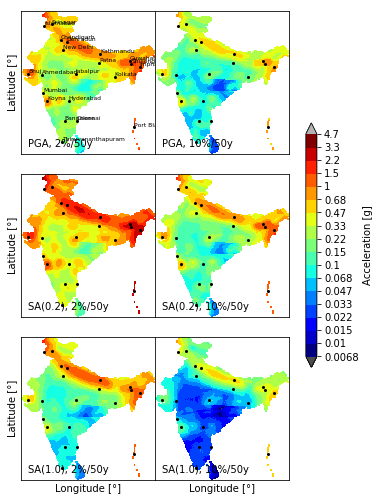

In [9]:
csv2raster(PUBLISHED_CSV)

## Calculated Results

Saving: map_collapsed_v2/hazard_map-mean_24323.tif
Saving: map_collapsed_v2/hazard_map-mean_24323.png
Saving: colormap_jet_0.0068-4.7.txt


'map_collapsed_v2/hazard_map-mean_24323.tif'

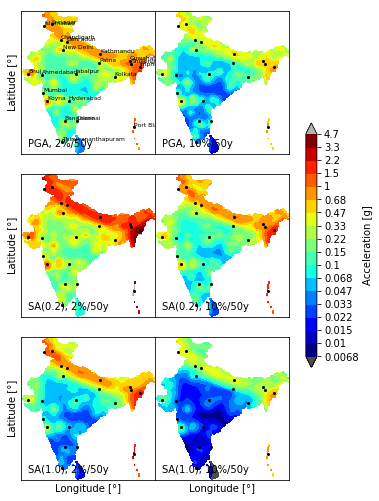

In [10]:
csv2raster(MAP_CSV)

In [11]:
df_calc, _ = read_hazard_map_csv(MAP_CSV)
zero_hazard = df_calc == 0
if zero_hazard.any().any():
    print('Setting points with zero hazard to NaN:')
    display(df_calc.loc[zero_hazard.any(axis=1)])
    df_calc.replace({0: np.NaN}, inplace=True)

Setting points with zero hazard to NaN:


imt            PGA             SA(0.2)            SA(1.0)          
poe       0.002105  0.000404  0.002105  0.000404 0.002105  0.000404
lon  lat                                                           
80.8 6.2  0.014716  0.044015  0.027265  0.077906      0.0  0.016931
81.0 6.2  0.013837  0.043122  0.025517  0.075627      0.0  0.015706
     6.4  0.014250  0.043630  0.026322  0.076917      0.0  0.016412
     6.6  0.014736  0.044225  0.027274  0.078382      0.0  0.017180
81.2 6.2  0.013362  0.042611  0.024582  0.074262      0.0  0.014916
     6.4  0.013614  0.042903  0.025073  0.075057      0.0  0.015402
     6.6  0.013913  0.043244  0.025663  0.075962      0.0  0.015921
     6.8  0.014252  0.043614  0.026335  0.076928      0.0  0.016463
     7.0  0.014600  0.043984  0.027023  0.077876      0.0  0.016983
     7.2  0.014955  0.044329  0.027728  0.078761      0.0  0.017474
     7.4  0.015227  0.044604  0.028346  0.079468      0.0  0.017864
     8.6  0.015136  0.043978  0.028125  0.078044      0.0  0.017175
81.4 6.4  0.013426  0.042613  0.024721  0.074333      0.0  0.015032
     6.6  0.013628  0.042817  0.025123  0.074914      0.0  0.015394
     6.8  0.013828  0.043021  0.025524  0.075484      0.0  0.015738
     7.0  0.014010  0.043207  0.025885  0.075993      0.0  0.016037
     7.2  0.014175  0.043365  0.026216  0.076420      0.0  0.016286
     7.4  0.014299  0.043472  0.026465  0.076707      0.0  0.016449
     7.6  0.014374  0.043524  0.026609  0.076847      0.0  0.016531
     7.8  0.014411  0.043518  0.026681  0.076839      0.0  0.016535
     8.0  0.014389  0.043449  0.026637  0.076658      0.0  0.016432
     8.2  0.014309  0.043327  0.026478  0.076338      0.0  0.016253
81.6 6.4  0.013788  0.042807  0.025463  0.074976      0.0  0.015500
     6.6  0.013990  0.042980  0.025873  0.075488      0.0  0.015829
     6.8  0.014134  0.043115  0.026163  0.075883      0.0  0.016080
     7.0  0.014208  0.043195  0.026313  0.076108      0.0  0.016213
     7.2  0.014218  0.043221  0.026335  0.076177      0.0  0.016252
     7.4  0.014162  0.043187  0.026224  0.076071      0.0  0.016179
     7.6  0.014052  0.043107  0.025999  0.075829      0.0  0.016023
     7.8  0.013921  0.042996  0.025733  0.075495      0.0  0.015808
81.8 7.4  0.014992  0.043803  0.027906  0.077842      0.0  0.017287

## Comparison

In [12]:
df_pub, _ = read_hazard_map_csv(PUBLISHED_CSV)
df_ratio = df_calc/df_pub

ratio_csv = os.path.splitext(os.path.basename(MAP_CSV))[0] + '_ratio.csv'
df_ratio_flat = df_ratio.copy()
df_ratio_flat.columns = ['-'.join(str(item) for item in items) for items in df_ratio.columns.tolist()]
df_ratio_flat.columns.name = None
df_ratio_flat.reset_index(inplace=True)

print('Saving: ' + ratio_csv)
if os.path.isfile(ratio_csv):
    os.remove(ratio_csv)

with open(ratio_csv, 'a') as file:
    file.write("# kind='mean', investigation_time=1.0\n")
    df_ratio_flat.to_csv(file, index=False)

Saving: hazard_map-mean_24323_ratio.csv


Saving: hazard_map-mean_24323_ratio.tif
Saving: hazard_map-mean_24323_ratio.png
Saving: colormap_bwr_0.3-3.txt


'hazard_map-mean_24323_ratio.tif'

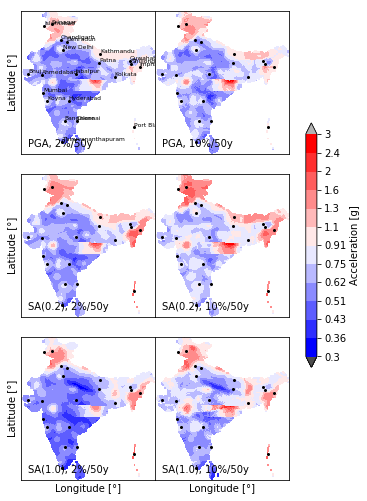

In [13]:
csv2raster(ratio_csv, colormap='bwr', limits=[0.3, 3], 
           symmetric=True, bins_per_decade=12)

In [14]:
error_df = gpd.GeoDataFrame(
    df_ratio_flat.dropna(), 
    geometry=[Point(lon, lat) for lon, lat in df_ratio.dropna().index],
    crs='WGS84').reset_index()
areal_df = gpd.GeoDataFrame(csv2areal(AREAL_CSV), crs='WGS84').reset_index()
areal_df = areal_df[areal_df['a'] != 0]

error_info_dfs = []
for layer_id in range(1, 5):
    error_info_dfs.append(gpd.sjoin(
        error_df, 
        areal_df[areal_df['layerid'] == layer_id], 
        how='left', op='within'))
error_info_df = pd.concat(error_info_dfs)
error_info_df.drop(columns='index_right', inplace=True) 

Reading: /home/nick/src/indian-subcontinent-psha/Source Models/nt2012_areal_source_model_v2.csv


In [16]:
info_columns = ['layerid', 'msr', 'tectonic zone', 'tectonic region type', 'zoneid']
error_columns = [column for column in error_info_df.columns if '-' in column]
for item in info_columns:
    summary_df = error_info_df[[item] + error_columns].groupby(item).aggregate(gmean)
    summary_df['total'] = summary_df.apply(gmean, axis=1)
    summary_df.sort_values('total', ascending=False, inplace=True)
    summary_df.loc['total'] = summary_df.apply(gmean, axis=0)
    display(summary_df)

,PGA-0.00040397,PGA-0.002105,SA(0.2)-0.00040397,SA(0.2)-0.002105,SA(1.0)-0.00040397,SA(1.0)-0.002105,total
layerid,,,,,,,
4.0,0.858087,0.912745,1.262016,1.291870,1.222968,1.187049,1.108344
3.0,0.901839,0.946241,1.063819,1.174235,0.896478,0.960664,0.985850
1.0,0.687415,0.754964,0.751624,0.876559,0.645684,0.793529,0.748029
2.0,0.680427,0.747450,0.739841,0.864576,0.634707,0.782596,0.738022
total,0.775649,0.835535,0.929540,1.035475,0.818723,0.917350,0.881289


,PGA-0.00040397,PGA-0.002105,SA(0.2)-0.00040397,SA(0.2)-0.002105,SA(1.0)-0.00040397,SA(1.0)-0.002105,total
msr,,,,,,,
StrasserIntraslab,0.946460,1.003196,1.125658,1.250565,0.945629,1.010420,1.041607
StrasserInterface,0.743549,0.723853,0.845571,0.886434,0.711612,0.758426,0.775626
WC1994,0.653517,0.725019,0.703830,0.830687,0.606758,0.765013,0.710448
total,0.771891,0.807474,0.875000,0.972889,0.741868,0.836940,0.831055


,PGA-0.00040397,PGA-0.002105,SA(0.2)-0.00040397,SA(0.2)-0.002105,SA(1.0)-0.00040397,SA(1.0)-0.002105,total
tectonic zone,,,,,,,
Active shallow crust,0.996916,1.093195,1.186266,1.363207,1.004533,1.077368,1.113623
Subduction intraslab,0.946460,1.003196,1.125658,1.250565,0.945629,1.010420,1.041607
Subduction interface,0.793367,0.779205,0.946945,0.978968,0.807891,0.838200,0.854056
Intraplate margin,0.706685,0.746887,0.752326,0.789586,0.770950,0.800795,0.760570
Stable continental,0.620214,0.690850,0.657937,0.783665,0.565253,0.731908,0.671156
total,0.800204,0.848936,0.910544,1.006453,0.803270,0.882345,0.872526


,PGA-0.00040397,PGA-0.002105,SA(0.2)-0.00040397,SA(0.2)-0.002105,SA(1.0)-0.00040397,SA(1.0)-0.002105,total
tectonic region type,,,,,,,
active shallow crust,1.001183,1.084682,1.228815,1.376240,1.050820,1.102210,1.134048
subduction intraslab,0.946460,1.003196,1.125658,1.250565,0.945629,1.010420,1.041607
subduction interface,0.743549,0.723853,0.845571,0.886434,0.711612,0.758426,0.775626
intraplate margin lower,0.709378,0.748468,0.761191,0.796238,0.776033,0.803657,0.765167
intraplate margin upper,0.703555,0.745046,0.742114,0.781897,0.765062,0.797468,0.755240
stable shallow crust,0.624572,0.696615,0.663213,0.789741,0.569751,0.737918,0.676448
no seismicity,0.499895,0.534831,0.514442,0.617737,0.442810,0.568905,0.526925
total,0.729353,0.772148,0.808297,0.895933,0.725622,0.809232,0.788033


,PGA-0.00040397,PGA-0.002105,SA(0.2)-0.00040397,SA(0.2)-0.002105,SA(1.0)-0.00040397,SA(1.0)-0.002105,total
zoneid,,,,,,,
17.0,1.195034,1.219847,1.419720,1.564250,1.415110,1.452604,1.371478
98.0,1.205242,1.281997,1.413356,1.585260,1.356898,1.380136,1.365517
13.0,1.203905,1.275753,1.412767,1.578992,1.349502,1.380350,1.361953
916.0,0.939148,0.938398,1.621434,1.529020,1.709335,1.532687,1.337475
166.0,0.936619,0.940618,1.622122,1.529759,1.692651,1.535688,1.335854
131.0,0.930156,0.938119,1.612402,1.516972,1.665462,1.518096,1.324392
128.0,1.062967,1.048768,1.603129,1.518826,1.456288,1.348059,1.321616
164.0,1.017787,1.047204,1.593947,1.557908,1.400002,1.286590,1.297315
163.0,1.029432,1.037978,1.535071,1.459400,1.374512,1.272367,1.269526


In [17]:
for layerid in range(1, 5):
    gmpes_changed = (
        (areal_df['tectonic region type'] == 'subduction interface') &
        (areal_df['layerid'] == layerid))
    if any(gmpes_changed):
        print(layerid, areal_df[gmpes_changed].zoneid.tolist())

1 [14, 21, 22, 910, 916, 918]
2 [89, 91, 110, 130, 132]


## Test interpolation of sites from map

In [18]:
city = df_cities.loc['Srinagar']
city

Latitude (°N)     34.08
Longitude (°E)     74.8
BIS                0.18
zone                  V
GSHAP              0.25
Present            0.33
Other               NaN
Reference           NaN
Name: Srinagar, dtype: object

In [19]:
def get_near(df, city):
    delta_x = np.abs(df.index.get_level_values('lon') - city['Longitude (°E)'])
    delta_y = np.abs(df.index.get_level_values('lat') - city['Latitude (°N)'])
    index = np.where((delta_x == delta_x.min()) & (delta_y == delta_y.min()))[0][0]
    return df.iloc[index]

In [20]:
df_comparison = pd.concat((get_near(df_calc, city).round(3), 
                           get_near(df_pub, city).round(3), 
                           (100*(get_near(df_ratio, city) - 1)).round(1)), axis=1).T
df_comparison.index = ['current', 'published', 'change [%]']
df_comparison.reindex(sorted(df_comparison.columns), axis=1)
df_comparison.T

current  published  change [%]
imt     poe                                     
PGA     0.000404    0.783      0.650        20.4
        0.002105    0.424      0.329        28.7
SA(0.2) 0.000404    1.659      1.173        41.4
        0.002105    0.854      0.539        58.6
SA(1.0) 0.000404    0.982      0.814        20.7
        0.002105    0.350      0.288        21.5